# **MPS $\to$ Quantum Circuit**

**Objective:** Embed a Matrix Product State into a quantum circuit such that the two output states are the same
    $$\langle\psi_\text{MPS}|\psi_\text{QC}\rangle = 1$$

<img 
    src="assets/mpstoqc_scheme.svg" 
    alt="Scheme for conversion"
    style="background-color:white;"
    width = "50%" />

#### Literature Review:
- [3]: **Preparation of Matrix Product States with Log-Depth Quantum Circuit**, (2024) _arXiv:2307.01696_
    > Depth = $O[\log(N)]$ (N number of spins) \
    > 🛑 Only for Translation-Invariant MPS
- [4]: **Constant-depth preparation of matrix product states with adaptive quantum circuits**, (2024) _arXiv:2404.16083_
    > 🛑 Only for Translation-Invariant MPS
- [2]: **Encoding of Matrix Product States into Quantum Circuits of One- and Two-Qubit Gates**, (2020) _arXiv:1908.07958_  
    > ✅ Approximated algorithm used in this Notebook

- [1]: **Sequential generation of entangled multi-qubit gates**, (2018) _arXiv:2311.05050_  
    > ⬆️ Used by [2] to build the used algorithm 

### **Encoding of Matrix Product States into Quantum Circuits of One- and Two-Qubit Gates**

##### Maximum Bond dimension = 2

We can __exactly__ encode an MPS with maximum bond dimension $\chi_\text{max} = 2$ into a brick-wall Quantum Circuit of depth 1:

<img 
    src="assets/mpstoqc_exact.svg" 
    alt="Scheme for conversion"
    style="background-color:white;"
    width = "50%" />


This conversion has **no approximation error** meaning that the state represented by the two object is the exact same: 

$$\text{Fidelity:   } \left|\langle\psi_\text{MPS}|\psi_\text{QC}\rangle\right|^2 = 1$$

##### Maximum Bond dimension > 2

<img 
    src="assets/mpstoqc_approx.svg" 
    alt="Scheme for conversion"
    style="background-color:white;"
    width = "50%" />

In [1]:
import pickle
import os

import numpy as np
import pennylane as qml
import quimb as qu

import matplotlib.pyplot as plt

from PhaseEstimation.utils.math import fidelity
from PhaseEstimation.utils.tn import pad_mps, mps_to_qc

data_folder = '/home/samonaco/Quantum-Phase-Detection-ANNNI/data/'

### Encoding matrix product state into single-layer quantum circuit
We temporarily assume

$$d = \chi = 2$$

* $\chi$ is the maximum bond dimension
* d is the physical dimension

In [2]:
N = 9   # Number of spins
chi = 2 # Maximum Bond dimension

In [3]:
# Load the dictionary of ANNNI states
mps_dict = pickle.load(open(os.path.join(data_folder, f'ANNNI_L{N}_X{chi}.pkl'), 'rb'))
# Select a state
k, h = list(mps_dict.keys())[500]
mps_raw = mps_dict[k, h]
# Load the state as a MPS class in quimb
mps = qu.tensor.tensor_1d.MatrixProductState(mps_raw[1], shape='lpr')

In [4]:
dev = qml.device('default.qubit', wires=9)
circuit_dec, circuit, = mps_to_qc(mps)

@qml.qnode(dev)
def q_circuit():
    circuit()
    return qml.state()

@qml.qnode(dev)
def q_circuit_dec():
    circuit_dec()
    return qml.state()

/home/samonaco/Quantum-Phase-Detection-ANNNI/src/PhaseEstimation/utils/math.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  unitary[:, j] = col / np.linalg.norm(col)


(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

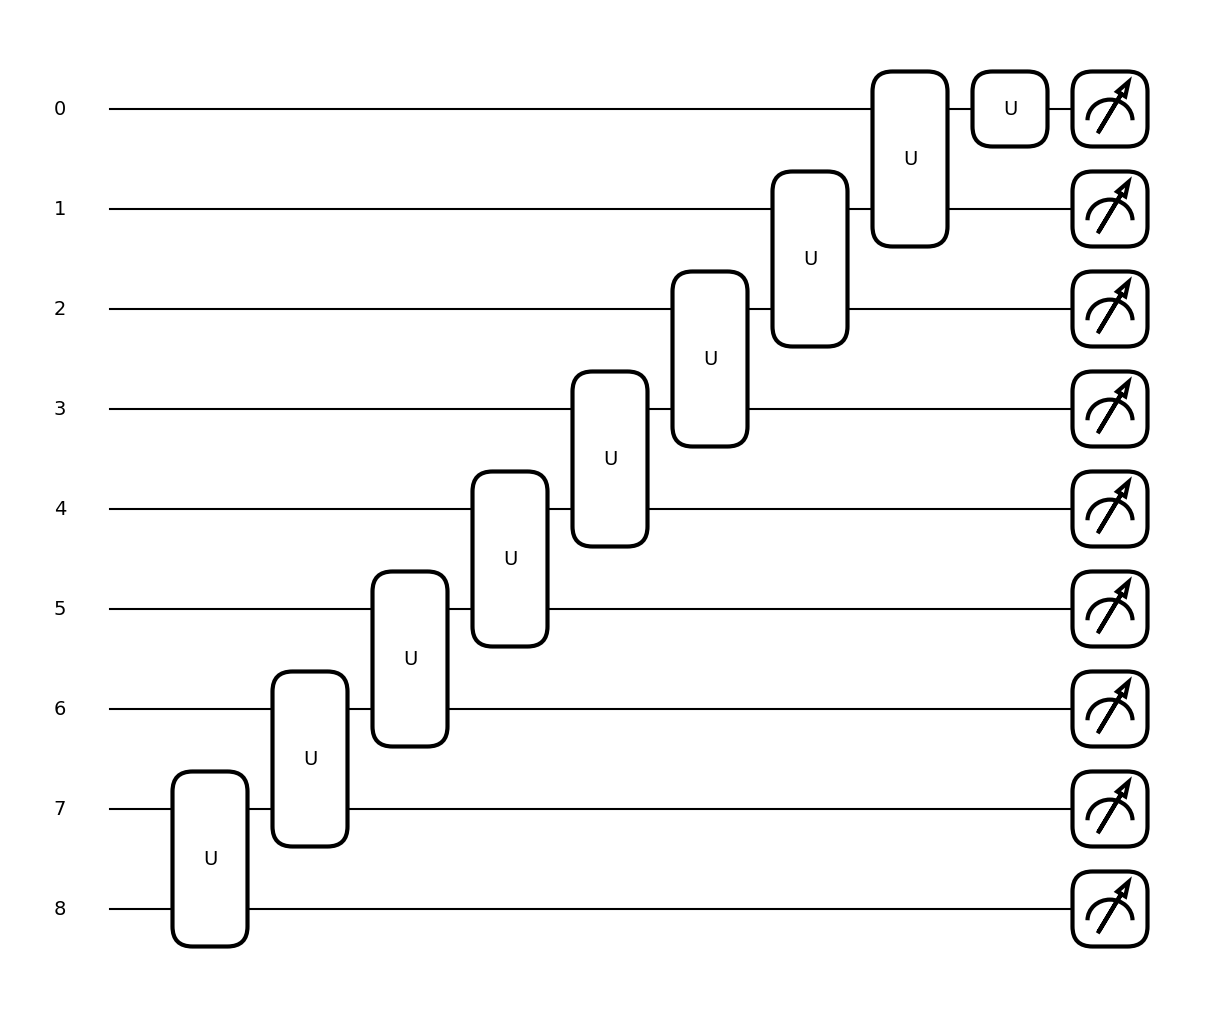

In [5]:
qml.draw_mpl(q_circuit)()

### Encoding matrix product state into quantum circuit
$$\chi > d = 2$$

The encoding algorithm is as followin:
1. For the MPS $|\psi_k\rangle$ in the $k$-th iteration

In [6]:
chi = 64

In [7]:
# Load the dictionary of ANNNI states
mps_dict = pickle.load(open(os.path.join(data_folder, f'ANNNI_L9_X{chi}.pkl'), 'rb'))
# Select a state
k, h = list(mps_dict.keys())[540]
mps_raw = mps_dict[k, h]
# Load the state as a MPS class in quimb
mps8 = qu.tensor.tensor_1d.MatrixProductState(mps_raw[1], shape='lpr')

In [8]:
dev = qml.device('default.qubit', wires=9)
circuit8_dec, circuit8, = mps_to_qc(mps8, depth = 3)

@qml.qnode(dev)
def q_circuit8():
    circuit8()
    return qml.state()

@qml.qnode(dev)
def q_circuit8_dec():
    circuit8_dec()
    return qml.state()

/home/samonaco/Quantum-Phase-Detection-ANNNI/src/PhaseEstimation/utils/math.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  unitary[:, j] = col / np.linalg.norm(col)


(<Figure size 1600x1000 with 1 Axes>, <Axes: >)

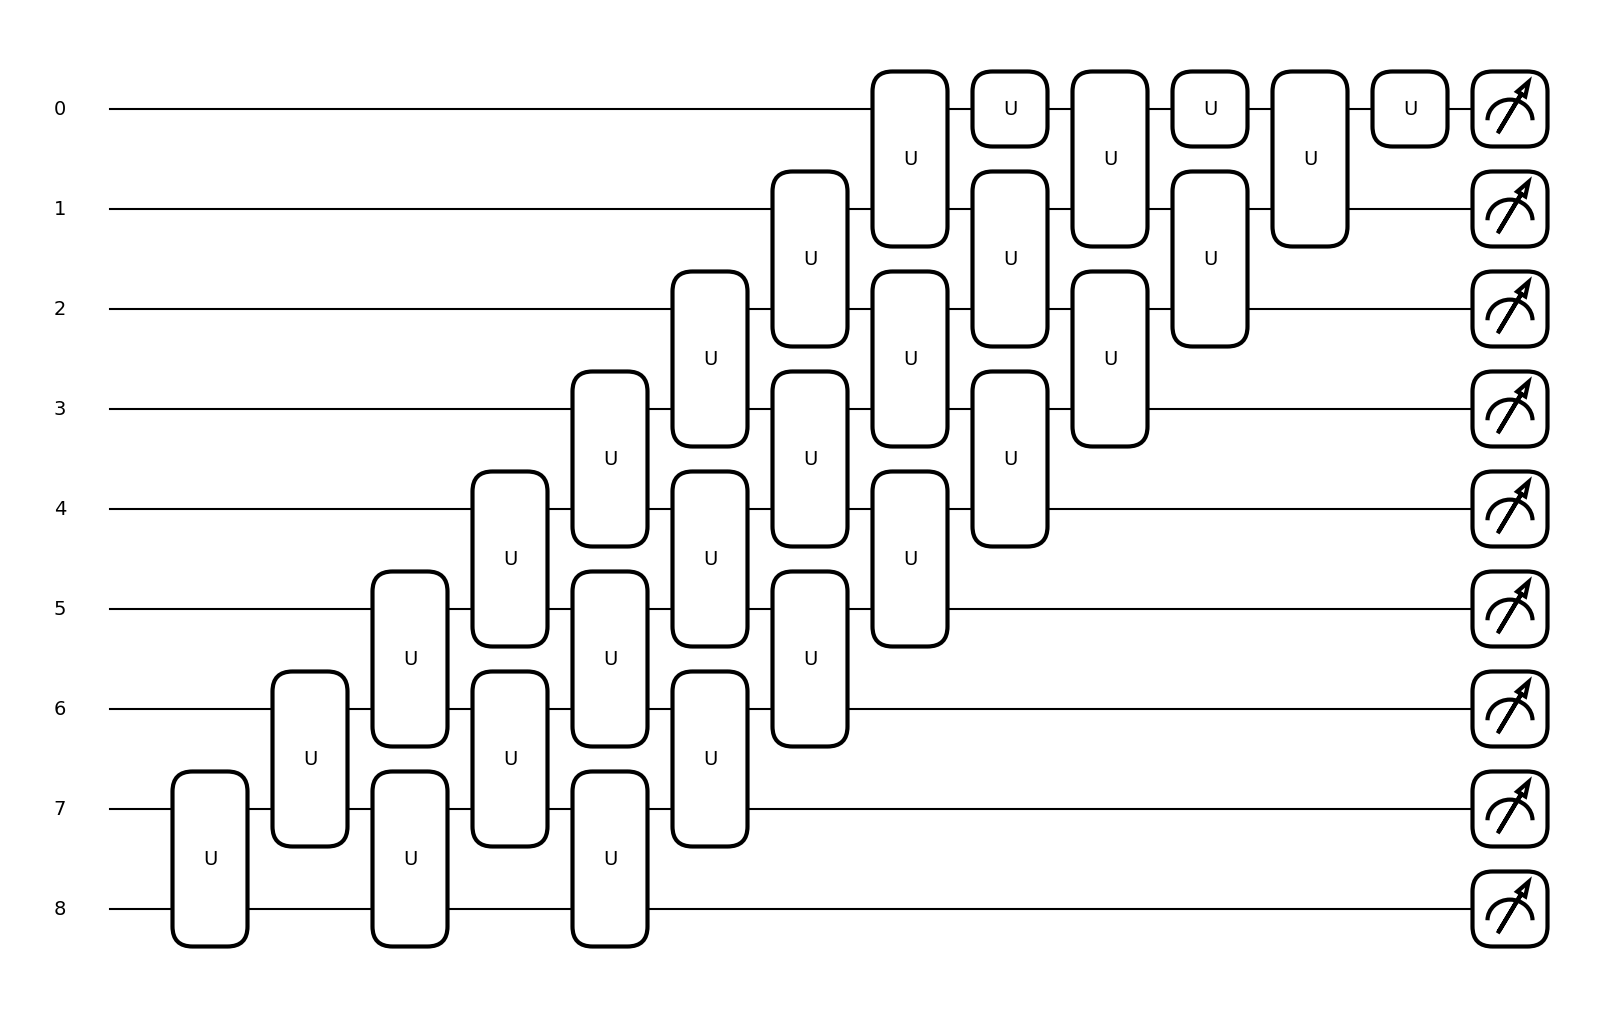

In [9]:
qml.draw_mpl(q_circuit8)()

In [10]:
fidelity(mps8.to_dense(), q_circuit8())

np.float64(0.9427229429218669)

### Depth analysis

/home/samonaco/Quantum-Phase-Detection-ANNNI/src/PhaseEstimation/utils/math.py:46: ComplexWarning: Casting complex values to real discards the imaginary part
  unitary[:, j] = col / np.linalg.norm(col)


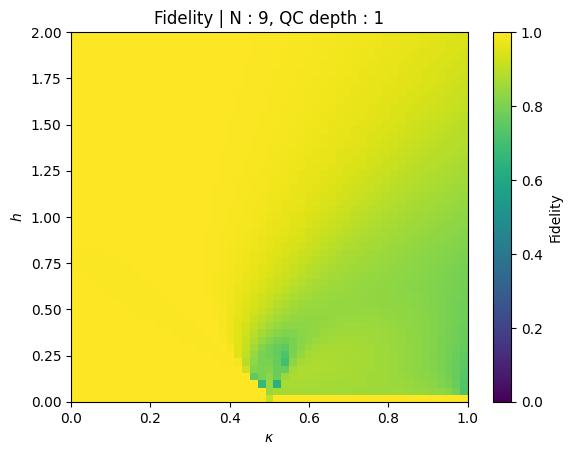

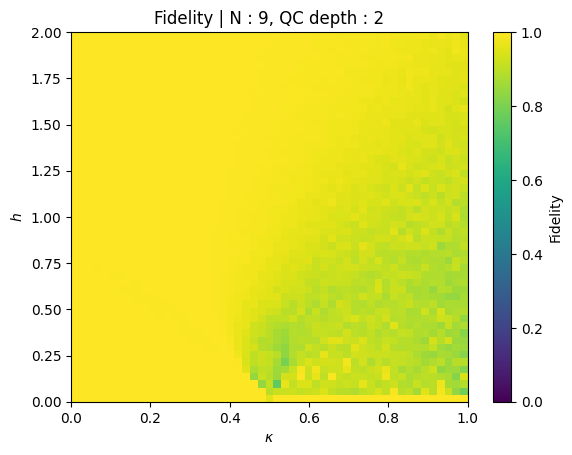

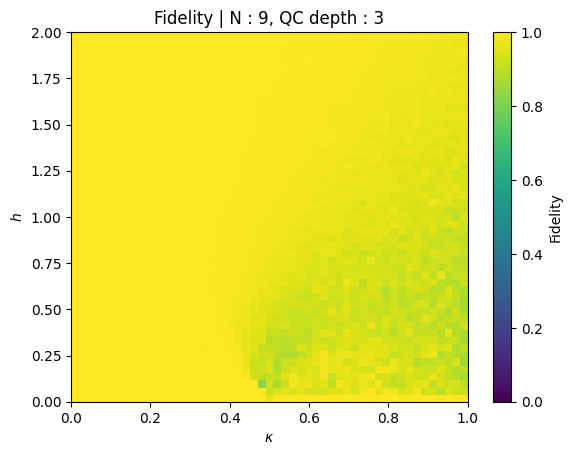

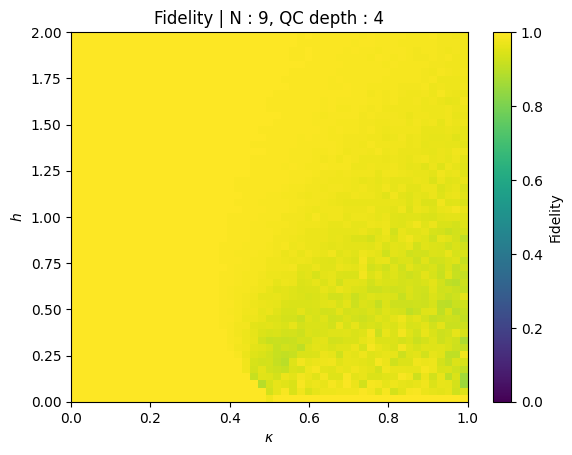

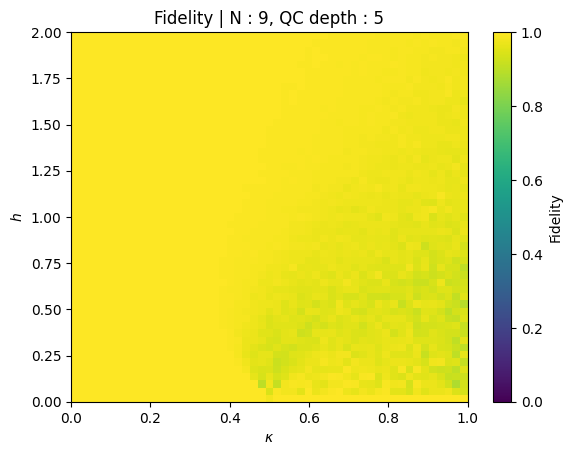

In [11]:
p_k = np.sort(np.unique([x for (x, _) in mps_dict.keys()]))
p_h = np.sort(np.unique([x for (_, x) in mps_dict.keys()]))

# Create a 2D array to store fidelity values
fidelity_map = np.zeros((len(p_h), len(p_k)))

# Fill the array
for depth in [1, 2, 3, 4, 5]:
    for i, h in enumerate(p_h):
        for j, k in enumerate(p_k):
            # print(i, j, k, h)
            mps8 = qu.tensor.tensor_1d.MatrixProductState(mps_dict[float(k), float(h)][1], shape='lpr')
            mps8 = pad_mps(mps8, chi = mps8.max_bond())
            qc_mps, qcU_mps = mps_to_qc(mps8, depth=depth)
            @qml.qnode(dev)
            def qqcU_mps():
                qcU_mps()
                return qml.state()
            fidelity_map[i, j] = fidelity(mps8.to_dense(), qqcU_mps())

# Display with imshow
    plt.imshow(fidelity_map[:, :], origin='lower', extent=(min(p_k), max(p_k), min(p_h), max(p_h)),
               aspect='auto', cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label='Fidelity')
    plt.xlabel(r'$\kappa$')
    plt.ylabel(r'$h$')
    plt.title(f'Fidelity | N : {N}, QC depth : {depth}')
    plt.show()

---
## Resources:
- [1]: **Sequential generation of entangled multi-qubit gates**, (2018) _arXiv:2311.05050_  
- [2]: **Encoding of Matrix Product States into Quantum Circuits of One- and Two-Qubit Gates**, (2020) _arXiv:1908.07958_  
- [3]: **Preparation of Matrix Product States with Log-Depth Quantum Circuit**, (2024) _arXiv:2307.01696_
- [4]: **Constant-depth preparation of matrix product states with adaptive quantum circuits**, (2024) _arXiv:2404.16083_